# MedBioNotebook


#### In this notebook we will work with (invented) data coming from spine images and we will investigate genetic basis that underlies the process of degeneration of the spine. The steps we will follow are:

- Examine the file formats for input data
- Generate basic descriptive statistics for the whole genome SNP data
- Perform basic quality control filtering
- Perform a basic association analysis


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, beta, norm, binom
from scipy.stats.mstats import mquantiles
from itertools import cycle
!chmod 777 ../tools/plink

## Phenotypes and covariates

Phenotypes and covariates are different characteristics that has been registered from the different subjects and relate to the measure that wants to be associated with differential genetic profiles. We define phenotype to a measure that relates to a physiological characteristic and that wants to be assessed. Similarly, covariates are same type of measures that may influence the phenotype expression and thus need to be included in the analysis. Depending on the GWA study then, a measure can be a covariate or the phenotype to be tested.


### LOAD DATA

In [2]:
pheno = pd.read_csv('../data/Phen.tsv',sep = '\t',index_col = 0)
covar = pd.read_csv('../data/Cova.tsv',sep = '\t',index_col = 0)


In [3]:
pheno.head()

,ProjectID,ModicChanges,Pfirrmann,herniation,Signal_Intensity_change,Schmorls_Nodes,Disc_narrowing,BackPain
0,CH18526,0.0,2.0,0.0,0.0,0.0,0.0,1.0
1,CH18524,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,CH18529,2.0,2.0,0.0,1.0,0.0,0.0,1.0
3,CH18558,2.0,2.0,0.0,1.0,0.0,0.0,1.0
4,CH18532,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [4]:
covar.head()


,ProjectID,Sex,Age,BMI,BackPain
0,CH18526,1.0,58.0,21.0,1.0
1,CH18524,1.0,47.0,27.0,1.0
2,CH18529,1.0,51.0,16.0,1.0
3,CH18558,0.0,50.0,28.0,1.0
4,CH18532,0.0,61.0,26.0,1.0


                            which are the categorical, continuous and binary variables?

### CHECK DISTRIBUTIONS  

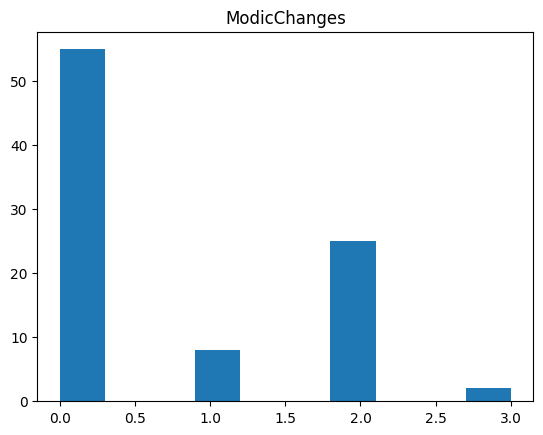

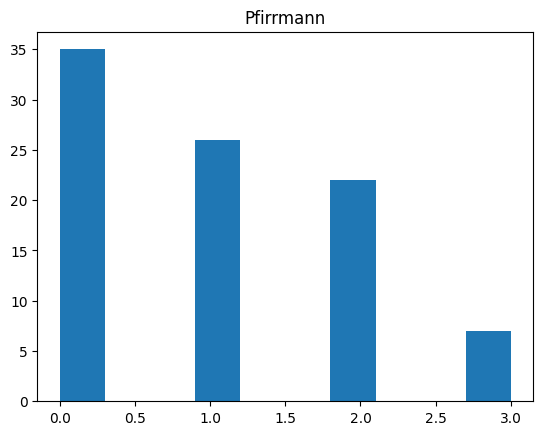

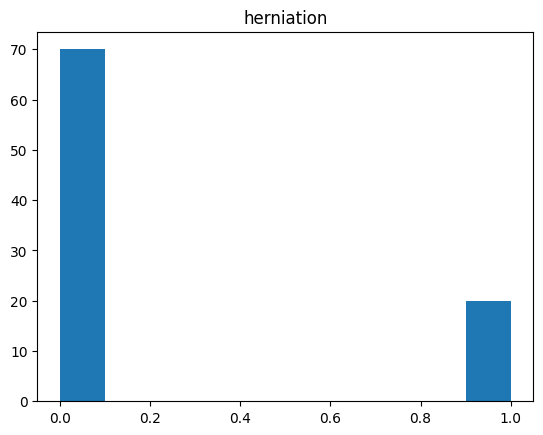

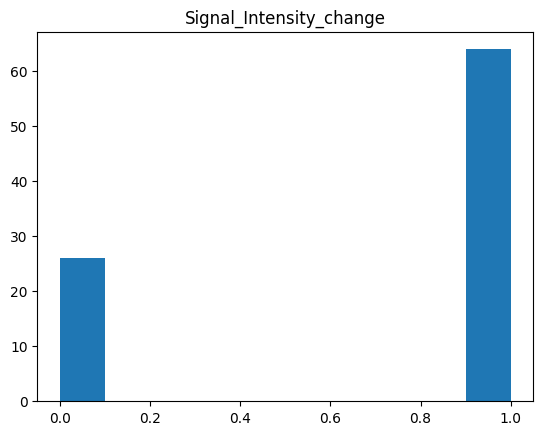

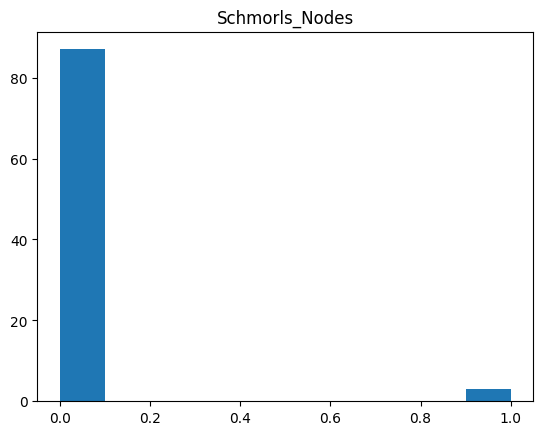

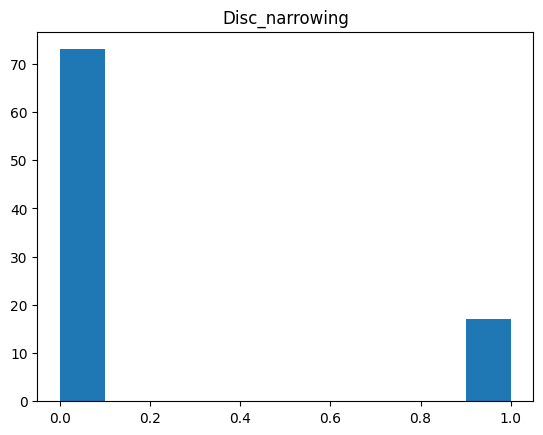

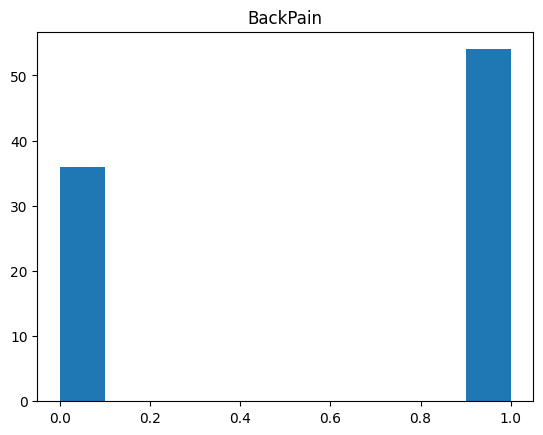

In [5]:
for column in list(pheno.columns)[1:]: #remove the ID column
    plt.figure()
    plt.hist(pheno[column])
    plt.title(column)

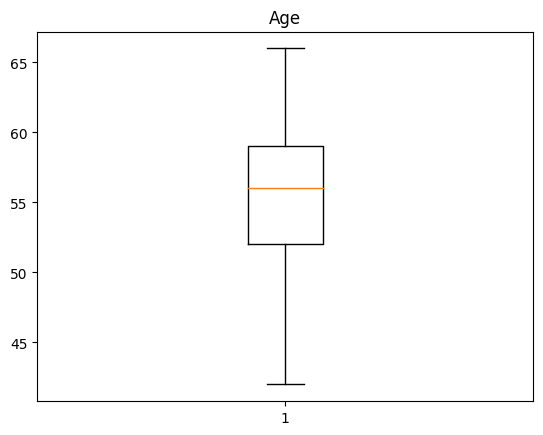

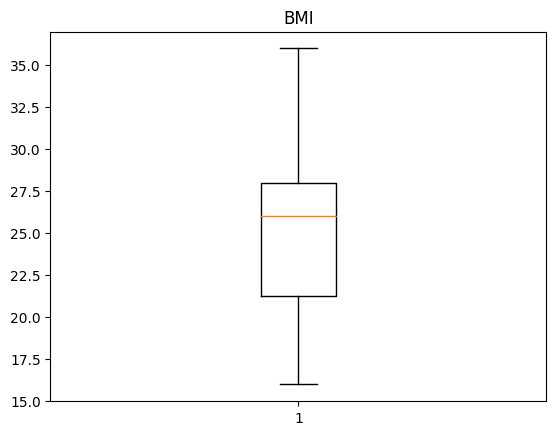

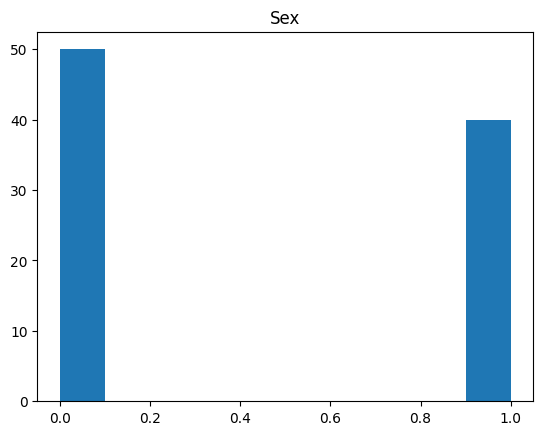

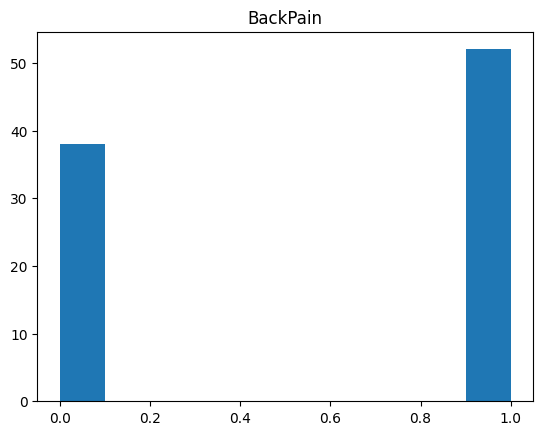

In [6]:
for column in ['Age', 'BMI']:
    plt.figure()
    plt.boxplot(covar[column])
    plt.title(column)
for column in ['Sex', 'BackPain']:
    plt.figure()
    plt.hist(covar[column])
    plt.title(column)

                            Let's try to interpret what the plots are telling us

# Now we want to decide our phenotype of interest 

This is up to you, we can use a plain phenotype, make a combination of phenotypes, transform them in binary leave it as they are etc..

In [7]:
pheno['new_phenotype'] = pheno[pheno.columns[1:]].sum(axis=1)

In [8]:
pheno['new_phenotype'] = pheno.new_phenotype.apply(lambda x: 2 if x > 3 else 1)

# Investigate the genetic data

Plink works with different data types, [here](https://www.cog-genomics.org/plink/1.9/formats#fam) we can learn more about it.

The data used in this exercise are from the 90 Asian HapMap individuals (Han Chinese from Beijing and Japanese from Tokyo). From the actual HapMap SNP data, ~250,000 SNPs have been extracted, which are the autosomal SNPs on half of the Affymetrix 500K SNP Array product.

- wgas1.ped	Genotype data for 228,694 SNPs on 90 individuals
- wgas1.map	Map file for these SNPs


### PED files contain genotype information (one person per row) 

The PED file is where genotype data is stored, every row is a sample and the columns are divided as follows
- Family ID
- Individual ID
- Paternal ID
- Maternal ID
- Sex (1=male; 2=female; other=unknown)
- Phenotype (1=unaffected,2=affected) 
- Genotype (2 x number of variants tested for every individual)

Contains no header line, and one line per sample with 2V+6 fields where V is the number of variants. The first six fields are the same as those in a .fam file. The seventh and eighth fields are allele calls for the first variant in the .map file ('0' = no call); the 9th and 10th are allele calls for the second variant; and so on.


In [9]:
with open('../data/genetic_data.ped','r') as f:
    genetic_ped = f.readlines()
    
genetic_ped[0][:50] # Takes the first 50 characters of the first sample

'CH18526 NA18526 0 0 2 A A G G A A T T C C T T T G '

In [10]:
# Visualize the ped file in a pandas Dataframe
ped_file = pd.DataFrame([line.split() for line in genetic_ped])

In [11]:
ped_file.head()

,0,1,2,3,4,5,6,7,8,9,...,457383,457384,457385,457386,457387,457388,457389,457390,457391,457392
0,CH18526,NA18526,0,0,2,A,A,G,G,A,...,A,A,C,T,C,T,A,A,T,T
1,CH18524,NA18524,0,0,1,A,A,G,G,A,...,A,A,T,T,C,T,G,G,T,T
2,CH18529,NA18529,0,0,2,G,A,G,G,G,...,C,A,T,T,C,C,G,A,T,T
3,CH18558,NA18558,0,0,1,A,A,G,G,A,...,A,A,T,T,T,T,G,A,T,T
4,CH18532,NA18532,0,0,2,A,A,G,G,A,...,C,C,T,T,T,T,G,A,T,T


In [12]:
# Shape we will tell us the number of rows and column of the data
ped_file.shape

(90, 457393)

### We need to insert the phenotype we decided in the 6 column of the dataframe (index = 5)

In [13]:
ped_file.insert(5,'disc_phenotype',pheno.new_phenotype.astype(int))

In [14]:
ped_file.head()

,0,1,2,3,4,disc_phenotype,5,6,7,8,...,457383,457384,457385,457386,457387,457388,457389,457390,457391,457392
0,CH18526,NA18526,0,0,2,1,A,A,G,G,...,A,A,C,T,C,T,A,A,T,T
1,CH18524,NA18524,0,0,1,1,A,A,G,G,...,A,A,T,T,C,T,G,G,T,T
2,CH18529,NA18529,0,0,2,2,G,A,G,G,...,C,A,T,T,C,C,G,A,T,T
3,CH18558,NA18558,0,0,1,2,A,A,G,G,...,A,A,T,T,T,T,G,A,T,T
4,CH18532,NA18532,0,0,2,1,A,A,G,G,...,C,C,T,T,T,T,G,A,T,T


### Save the .ped file with the phenotype in the 6 column


In [15]:
ped_file.to_csv('./plink_input.ped', sep = ' ', header = False, index = False)
!cp ../data/genetic_data.map ../data/plink_input.map #change the name to plink_input so that plink finds the map file

### MAP file 

Variant information file accompanying a .ped text pedigree + genotype table. Also generated by "--recode rlist".

A text file with no header line, and one line per variant with the following 3-4 fields:

- Chromosome code. PLINK 1.9 also permits contig names here, but most older programs do not.
- Variant identifier
- Position in morgans or centimorgans (optional; also safe to use dummy value of '0')
- Base-pair coordinate
- All lines must have the same number of columns (so either no lines contain the morgans/centimorgans column, or all of them do).

In [16]:
with open('../data/genetic_data.map','r') as f:
    genetic_map = f.readlines()
    
genetic_map_df = pd.DataFrame([a.rstrip('\n').split('\t') for a in genetic_map],columns = ['chr','rsid','pos_cM','pos_bp'])
genetic_map_df

,chr,rsid,pos_cM,pos_bp
0,1,rs3094315,0.792429,792429
1,1,rs6672353,0.817376,817376
2,1,rs4040617,0.819185,819185
3,1,rs2905036,0.832343,832343
4,1,rs4245756,0.839326,839326
...,...,...,...,...
228689,22,rs6009945,49.3794,49379357
228690,22,rs9616913,49.4057,49405670
228691,22,rs739365,49.4305,49430460
228692,22,rs6010063,49.4471,49447077


# Allele frequencies

To generate a list of minor allele frequencies (MAF) for each SNP, based on all founders in the sample:

In [23]:
!../tools/plink --file ../data/plink_input --freq


PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink.log.
Options in effect:
  --file ../data/plink_input
  --freq

15841 MB RAM detected; reserving 7920 MB for main workspace.
.ped scan complete (for binary autoconversion).32425262728303132333435363738404142434445464748505152535455565758606162636465666768707172737475767778808182838485868788909192939495969798100%
Performing single-pass .bed write (228694 variants, 90 people).
--file: plink-temporary.bed + plink-temporary.bim + plink-temporary.fam546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394%
written.
228694 variants loaded from .bim file.
90 people (45 males, 45 females) loaded from .fam.
38 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 90 founders and 0 nonfounders present.
Calculating all

with five columns:
-     CHR       Chromosome
-     SNP       SNP identifier
-     A1        Allele 1 code (minor allele)
-     A2        Allele 2 code (major allele)
-     MAF       Minor allele frequency
-     NCHROBS   Non-missing allele count

In [112]:
with open('plink.frq', 'r') as f:
    frequencies = f.readlines()
frequencies = pd.DataFrame([a.rstrip('\n').split() for a in frequencies])
frequencies.columns = frequencies.iloc[0]
frequencies.drop(0,inplace = True)
frequencies

,CHR,SNP,A1,A2,MAF,NCHROBS
1,1,rs3094315,G,A,0.1236,178
2,1,rs6672353,A,G,0.005618,178
3,1,rs4040617,G,A,0.1167,180
4,1,rs2905036,0,T,0,180
5,1,rs4245756,0,C,0,180
...,...,...,...,...,...,...
228690,22,rs6009945,C,A,0.3652,178
228691,22,rs9616913,C,T,0.1056,180
228692,22,rs739365,C,T,0.4111,180
228693,22,rs6010063,G,A,0.4444,180


## Now up to you:

- Calculate the mean, min and max MAF of the sample 
- Plot a boxplot of the MAF


# Hardy Weinberg equilibrium

To generate a list of genotype counts and Hardy-Weinberg test statistics for each SNP (using chi squared or fisher). In this test 
- $H_{0} = $ the obsrved values follow HWE aequlibrium, there's no divergence 
- $H_{1} = $ There is divergence from HWE aequilibrium 

This file has the following format
-     SNP             SNP identifier
-     TEST            Code indicating sample
-     A1              Minor allele code
-     A2              Major allele code
-     GENO            Genotype counts: 11/12/22 
-     O(HET)          Observed heterozygosity
-     E(HET)          Expected heterozygosity
-     P               H-W p-value

In [24]:
!../tools/plink --file ../data/plink_input --hardy

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink.log.
Options in effect:
  --file ../data/plink_input
  --hardy

15841 MB RAM detected; reserving 7920 MB for main workspace.
.ped scan complete (for binary autoconversion).32425262728303132333435363738404142434445464748505152535455565758606162636465666768707172737475767778808182838485868788909192939495969798100%
Performing single-pass .bed write (228694 variants, 90 people).
--file: plink-temporary.bed + plink-temporary.bim + plink-temporary.fam546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394%
written.
228694 variants loaded from .bim file.
90 people (45 males, 45 females) loaded from .fam.
38 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 90 founders and 0 nonfounders present.
Calculating al

In [25]:
with open('plink.hwe', 'r') as f:
    hwe = f.readlines()
hwe = pd.DataFrame([a.rstrip('\n').split() for a in hwe])
hwe.columns = hwe.iloc[0]
hwe.drop(0,inplace = True)
hwe

,CHR,SNP,TEST,A1,A2,GENO,O(HET),E(HET),P
1,1,rs3094315,ALL,G,A,0/22/67,0.2472,0.2166,0.3476
2,1,rs3094315,AFF,G,A,0/0/0,nan,nan,1
3,1,rs3094315,UNAFF,G,A,0/11/27,0.2895,0.2476,1
4,1,rs6672353,ALL,A,G,0/1/88,0.01124,0.01117,1
5,1,rs6672353,AFF,A,G,0/0/0,nan,nan,1
...,...,...,...,...,...,...,...,...,...
686078,22,rs6010063,AFF,G,A,0/0/0,nan,nan,1
686079,22,rs6010063,UNAFF,G,A,6/21/11,0.5526,0.4913,0.5266
686080,22,rs9616985,ALL,C,T,0/6/84,0.06667,0.06444,1
686081,22,rs9616985,AFF,C,T,0/0/0,nan,nan,1


## Now up to you:

- Calculate how many snps have p value significant (<=0.05)
- Let's interpret together meaning of this, why do we exclude significant SNPs?


# Missing rates 

In [28]:
!../tools/plink --file ../data/plink_input --missing --out miss_stat


PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to miss_stat.log.
Options in effect:
  --file ../data/plink_input
  --missing
  --out miss_stat

15841 MB RAM detected; reserving 7920 MB for main workspace.
.ped scan complete (for binary autoconversion).32425262728303132333435363738404142434445464748505152535455565758606162636465666768707172737475767778808182838485868788909192939495969798100%
Performing single-pass .bed write (228694 variants, 90 people).
--file: miss_stat-temporary.bed + miss_stat-temporary.bim +940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394%
miss_stat-temporary.fam written.
228694 variants loaded from .bim file.
90 people (45 males, 45 females) loaded from .fam.
38 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 90 fo

lmiss: for each SNP we see the number of missing individuals (N_MISS) and the proportion (F_MISS)

imiss: the same but variantwise

In [29]:
with open('miss_stat.lmiss','r') as f:
    lmiss = f.readlines()
    
lmiss = pd.DataFrame([i.split() for i in lmiss])

new_columns = lmiss.iloc[0]

lmiss.drop(0,inplace = True)

lmiss.columns = new_columns
lmiss

,CHR,SNP,N_MISS,N_GENO,F_MISS
1,1,rs3094315,1,90,0.01111
2,1,rs6672353,1,90,0.01111
3,1,rs4040617,0,90,0
4,1,rs2905036,0,90,0
5,1,rs4245756,0,90,0
...,...,...,...,...,...
228690,22,rs6009945,1,90,0.01111
228691,22,rs9616913,0,90,0
228692,22,rs739365,0,90,0
228693,22,rs6010063,0,90,0


In [30]:
with open('miss_stat.imiss','r') as f:
    imiss = f.readlines()
    
imiss = pd.DataFrame([i.split() for i in imiss])

new_columns = imiss.iloc[0]

imiss.drop(0,inplace = True)

imiss.columns = new_columns
imiss 

,FID,IID,MISS_PHENO,N_MISS,N_GENO,F_MISS
1,CH18526,NA18526,Y,1057,228694,0.004622
2,CH18524,NA18524,Y,967,228694,0.004228
3,CH18529,NA18529,N,638,228694,0.00279
4,CH18558,NA18558,N,2342,228694,0.01024
5,CH18532,NA18532,Y,1408,228694,0.006157
...,...,...,...,...,...,...
86,JA19005,NA19005,Y,809,228694,0.003537
87,JA18999,NA18999,N,4121,228694,0.01802
88,JA19007,NA19007,Y,1065,228694,0.004657
89,JA19003,NA19003,Y,7572,228694,0.03311


## Now up to you:

- Calculate the mean, max, and min of missingness for every sample (imiss.F_MISS)
- Create a boxplot out of the frequency column (**check the data types)



# Quality Control

After the exploratory analysis we will generate a quality control file by creating a binary file with different flags in order to filter the .ped file.

In [17]:
!../tools/plink --file ../data/plink_input --make-bed --geno 0.05 --hwe 0.01 --maf 0.05 --out plink_inputqc

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink_inputqc.log.
Options in effect:
  --file ../data/plink_input
  --geno 0.05
  --hwe 0.01
  --maf 0.05
  --make-bed
  --out plink_inputqc

15841 MB RAM detected; reserving 7920 MB for main workspace.
.ped scan complete (for binary autoconversion).32425262728303132333435363738404142434445464748505152535455565758606162636465666768707172737475767778808182838485868788909192939495969798100%
Performing single-pass .bed write (228694 variants, 90 people).
--file: plink_inputqc-temporary.bed + plink_inputqc-temporary.bim +3444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394%
plink_inputqc-temporary.fam written.
228694 variants loaded from .bim file.
90 people (45 males, 45 females) loaded from .fam.
90 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calc

## Three files are created with this command 
- the binary file that contains the raw genotype data plink_input.bed 
- a revsied map file plink_input.bim which contains two extra columns that give the allele names for each SNP
- and plink_input.fam which is just the first six columns of plink_input.ped

You can view the .bim and .fam files -- but do not try to view the .bed file, now working with binary files makes evrything faster

# Account for relatedness and etnicity background

As we learned during the theoretical presentation we should need to correct for sample relatedness and etnicity. We will partially skip this step for seek of time and data handling (data needed for this step are usually very big). Nevertheless we will learn about what a PCA is and how to perform it with plink.

In [18]:
! ../tools/plink --bfile plink_inputqc --pca --out plink_inputqc_pca

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink_inputqc_pca.log.
Options in effect:
  --bfile plink_inputqc
  --out plink_inputqc_pca
  --pca

15841 MB RAM detected; reserving 7920 MB for main workspace.
158681 variants loaded from .bim file.
90 people (45 males, 45 females) loaded from .fam.
90 phenotype values loaded from .fam.
Using up to 8 threads (change this with --threads).
Before main variant filters, 90 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.994142.
158681 variants and 90 people pass filters and QC.
Among remaining phenotypes, 38 are cases and 52 are controls.
Relationship matrix calculation complete.
--pca: Resu

In [37]:
with open('plink_inputqc_pca.eigenvec','r') as f:
    pca = f.readlines()
pca = pd.DataFrame([l.split() for l in pca])
pca.columns = ['ID','FID'] + [f'PC{i}' for i in range(1,len(pca.columns)-1)]
for col in pca.columns[2:]:
    pca[col] = pca[col].astype(float)
pca

,ID,FID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,CH18526,NA18526,0.103843,-0.058981,-0.141516,-0.022481,-0.039549,-0.028402,-0.032757,0.033196,...,0.076911,0.021436,0.128885,0.092453,-0.027952,-0.002990,0.088917,-0.112161,0.037677,-0.094835
1,CH18524,NA18524,0.117151,-0.021356,0.024601,0.015424,0.069886,-0.115994,0.035257,0.064450,...,0.033745,-0.319211,0.024259,0.031566,-0.060110,-0.132624,-0.203557,0.144585,0.134073,0.131387
2,CH18529,NA18529,0.109110,-0.015534,-0.102073,-0.053364,0.000213,-0.087401,-0.146392,0.037944,...,0.008304,-0.061653,0.230307,0.035207,0.009010,0.012481,0.096326,-0.149012,-0.100138,-0.141476
3,CH18558,NA18558,0.086511,-0.015774,0.199440,-0.073092,0.097331,-0.126538,0.081145,-0.146657,...,-0.039056,-0.099025,0.174862,0.185124,-0.011702,0.120867,-0.024135,-0.078102,0.049975,-0.294341
4,CH18532,NA18532,0.100317,-0.004033,0.077324,-0.100934,-0.100220,0.077484,-0.144800,-0.180062,...,0.213705,0.036092,-0.007234,-0.105800,0.061021,-0.145393,-0.034773,0.258815,-0.018193,0.004411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,JA19005,NA19005,-0.078263,-0.082480,-0.061558,-0.013567,0.015922,-0.068782,0.047218,-0.036728,...,-0.062381,-0.048651,-0.036384,-0.057550,0.037018,-0.147927,0.043125,0.069903,-0.027335,-0.008281
86,JA18999,NA18999,-0.100565,0.071387,-0.002524,-0.101969,-0.151382,0.127868,0.156666,0.031656,...,-0.155667,0.050617,0.047216,0.096574,-0.104609,-0.036556,0.032683,0.132487,-0.032653,-0.156785
87,JA19007,NA19007,-0.089754,-0.046775,0.119079,-0.004527,0.055772,0.117716,-0.000423,0.038590,...,0.089251,-0.144968,-0.104981,0.150561,-0.002161,-0.172135,0.271010,-0.062078,-0.083593,-0.090859
88,JA19003,NA19003,-0.113272,0.050968,0.066722,-0.289040,-0.057845,-0.019388,-0.044350,-0.017584,...,-0.037444,0.054718,0.122947,0.038892,-0.103129,0.044551,-0.016819,-0.071571,0.061817,0.175942


The first 10 principal components are the one that we should introduce in the association analysis in order to correct for twin relatedness.

## Now up to you:

- Plot the first 2 Components
- What we can say about our samples??
- How would you do for detect the populations?



# Run the analysis 



In [81]:
!../tools/plink --bfile plink_inputqc --logistic --covar ../data/covariates_for_plink.txt --out gwas_output 

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to gwas_output.log.
Options in effect:
  --bfile plink_inputqc
  --covar ../data/covariates_for_plink.txt
  --logistic
  --out gwas_output

15841 MB RAM detected; reserving 7920 MB for main workspace.
158681 variants loaded from .bim file.
90 people (45 males, 45 females) loaded from .fam.
90 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
--covar: 4 covariates loaded.
Before main variant filters, 90 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.994142.
158681 variants and 90 people pass filters and QC.
Among remaining phenotypes, 38 are cases and 

#### Probably we won't find higly significant associations because we are testing only 90 individues (usually a gwas test 500k-1M SNPs for 1k - 100k samples. The bigger sample size the better it is. However since we are testing many SNPs the significance of the p-value is not anymore 0.05 as normal but usually is $5x10^-8$

# Read the output of the association

- CHR       Chromosome
- SNP       SNP identifier
- BP        Physical position (base-pair)
- A1        Tested allele (minor allele by default) 
- TEST      Code for the test (see below)
- NMISS     Number of non-missing individuals included in analysis
- BETA/OR   Regression coefficient (--linear) or odds ratio (--logistic)
- STAT      Coefficient t-statistic 
- P         Asymptotic p-value for t-statistic

In [83]:
with open('gwas_output.assoc.logistic','r') as f:
    assoc = f.readlines()
assoc = pd.DataFrame([a.rstrip('\n').split() for a in assoc])
assoc.columns = assoc.iloc[0]
assoc.drop(0,inplace = True)

# erease the NA in pvalue column since we cannot assign significance to those SNPs
assoc.replace('NA',np.nan,inplace = True)

assoc   

,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P
1,1,rs3094315,792429,G,ADD,89,1.476,0.7083,0.4788
2,1,rs3094315,792429,G,COV1,89,0.8957,-0.2473,0.8047
3,1,rs3094315,792429,G,COV2,89,1.021,0.5204,0.6028
4,1,rs3094315,792429,G,COV3,89,0.9623,-0.8446,0.3984
5,1,rs3094315,792429,G,COV4,89,1.009,0.01941,0.9845
...,...,...,...,...,...,...,...,...,...
793401,22,rs6010063,49447077,G,ADD,90,0.9502,-0.1546,0.8771
793402,22,rs6010063,49447077,G,COV1,90,0.8558,-0.3513,0.7254
793403,22,rs6010063,49447077,G,COV2,90,1.027,0.6791,0.4971
793404,22,rs6010063,49447077,G,COV3,90,0.9621,-0.8499,0.3954


# Plot the Results

In [86]:
def _find_top_snp(sign_snp_data, ld_block_size, is_get_biggest=True):
    """
    :param sign_snp_data:  A 2D array: [[xpos1, yvalue1, text1], [xpos2, yvalue2, text2], ...]
    """
    top_snp = []
    tmp_cube = []
    for i, (_x, _y, text) in enumerate(sign_snp_data):
        if i == 0:
            tmp_cube.append([_x, _y, text])
            continue

        if _x > tmp_cube[-1][0] + ld_block_size:
            # Sorted by y_value in increase/decrease order and only get the first value [0], which is the TopSNP.
            top_snp.append(sorted(tmp_cube, key=(lambda x: x[1]), reverse=is_get_biggest)[0])
            tmp_cube = []

        tmp_cube.append([_x, _y, text])

    if tmp_cube:  # deal the last one
        top_snp.append(sorted(tmp_cube, key=(lambda x: x[1]), reverse=True)[0])

    return top_snp


def _sign_snp_regions(sign_snp_data, ld_block_size):
    """Create region according to the coordinate of sign_snp_data."""
    regions = []
    for i, (_x, _y, _t) in enumerate(sign_snp_data):
        if i == 0:
            regions.append([_x - ld_block_size, _x])
            continue

        if _x > regions[-1][1] + ld_block_size:
            regions[-1][1] += ld_block_size
            regions.append([_x - ld_block_size, _x])
        else:
            regions[-1][1] = _x

    # The last
    if regions:
        regions[-1][1] += ld_block_size

    return regions


def _find_SNPs_which_overlap_sign_neighbour_region(sign_snp_neighbour_region, x):
    """
    """
    x_size = len(x)
    reg_size = len(sign_snp_neighbour_region)
    index = []
    tmp_index = 0
    for i in range(x_size):
        _x = x[i]

        is_overlap = False
        iter_index = range(tmp_index, reg_size)
        for j in iter_index:
            if _x > sign_snp_neighbour_region[j][1]: continue
            if _x < sign_snp_neighbour_region[j][0]: break

            tmp_index = j
            is_overlap = True
            break

        if is_overlap:
            index.append(i)

    # return the index
    return index


def manhattanplot(data, chrom="CHR", pos="BP", pv="P", snp="SNP", logp=True, ax=None,
                  marker=".", color="#3B5488,#53BBD5", alpha=0.8,
                  title=None, xlabel="Chromosome", ylabel=r"$-log_{10}{(P)}$",
                  xtick_label_set=None, CHR=None, xticklabel_kws=None,
                  suggestiveline=1e-5, genomewideline=5e-8, sign_line_cols="#D62728,#2CA02C", hline_kws=None,
                  sign_marker_p=None, sign_marker_color="r",
                  is_annotate_topsnp=False, highlight_other_SNPs_indcs=None,
                  highlight_other_SNPs_color="r", highlight_other_SNPs_kwargs=None,
                  text_kws=None, ld_block_size=50000, **kwargs):

    if not isinstance(data, pd.DataFrame):
        raise ValueError("[ERROR] Input data must be a pandas.DataFrame.")
    if chrom not in data:
        raise ValueError("[ERROR] Column \"%s\" not found!" % chrom)
    if pos not in data:
        raise ValueError("[ERROR] Column \"%s\" not found!" % pos)
    if pv not in data:
        raise ValueError("[ERROR] Column \"%s\" not found!" % pv)
    if is_annotate_topsnp and (snp not in data):
        raise ValueError("[ERROR] You're trying to annotate a set of SNPs but "
                         "NO SNP \"%s\" column found!" % snp)
    if CHR is not None and xtick_label_set is not None:
        raise ValueError("[ERROR] ``CHR`` and ``xtick_label_set`` can't be set simultaneously.")

    data[[chrom]] = data[[chrom]].astype(str)  # make sure all the chromosome id are character.
    data[pv] = assoc[pv].astype(float)
    data[pos] = assoc[pos].astype(int)
    # Draw the plot and return the Axes
    if ax is None:
        # ax = plt.gca()
        _, ax = plt.subplots(figsize=(20, 10), facecolor="w", edgecolor="k")  # default

    if xticklabel_kws is None:
        xticklabel_kws = {}
    if hline_kws is None:
        hline_kws = {}
    if text_kws is None:
        text_kws = {}

    if "," in color:
        color = color.split(",")
    colors = cycle(color)

    last_xpos = 0
    xs_by_id = []  # use for collecting chromosome's position on x-axis
    x, y, c = [], [], []
    sign_snp_sites = []
    for seqid, group_data in data.groupby(by=chrom, sort=False):  # keep the raw order of chromosome

        if (CHR is not None) and (seqid != CHR):
            continue

        color = next(colors)
        for i, (site, p_value) in enumerate(zip(group_data[pos], group_data[pv])):
            if p_value == 0:
                p_value = 1e-300  # set it to a very small value if p-value is 0.

            y_value = -np.log10(p_value) if logp else p_value
            x.append(last_xpos + site)
            y.append(y_value)

            c.append(sign_marker_color if ((sign_marker_p is not None) and (p_value <= sign_marker_p)) else color)
            if (snp is not None) and (sign_marker_p is not None) and (p_value <= sign_marker_p):
                snp_id = group_data[snp].iloc[i]
                sign_snp_sites.append([last_xpos + site, y_value, snp_id])  # x_pos, y_value, text

        # ``xs_by_id`` is for setting up positions and ticks. Ticks should
        # be placed in the middle of a chromosome. The a new pos column is
        # added that keeps a running sum of the positions of each successive
        # chromsome.
        xs_by_id.append([seqid, last_xpos + (group_data[pos].iloc[0] + group_data[pos].iloc[-1]) / 2])
        last_xpos = x[-1]  # keep track so that chromosome will not overlap in the plot.

    if not x:
        raise ValueError("zero-size array to reduction operation minimum which has no "
                         "identity. This could be caused by zero-size array of ``x`` "
                         "in the ``manhattanplot(...)`` function.")

    if "marker" not in kwargs:
        kwargs["marker"] = marker
    
    # plot the main manhattan dot plot
    ax.scatter(x, y, c=c, alpha=alpha, edgecolors="none", **kwargs)

    if is_annotate_topsnp is not None:
        index = _find_SNPs_which_overlap_sign_neighbour_region(
            sign_snp_neighbour_region=_sign_snp_regions(sign_snp_sites, ld_block_size),
            x=x)

        # reset color for all SNPs which nearby the top SNPs.
        for i in index:
            ax.scatter(x[i], y[i], c=sign_marker_color, alpha=alpha, edgecolors="none", **kwargs)

    highlight_other_SNPs_kwargs = dict() if highlight_other_SNPs_kwargs is \
                                            None else highlight_other_SNPs_kwargs

    # highlight other SNPs
    if highlight_other_SNPs_indcs is not None:
        for i in highlight_other_SNPs_indcs:
            ax.scatter(x[i], y[i], c=highlight_other_SNPs_color,
                       alpha=alpha, edgecolors="none", **highlight_other_SNPs_kwargs)

    # Add GWAS significant lines
    if "color" in hline_kws:
        hline_kws.pop("color")

    sign_line_cols = sign_line_cols.split(",") if "," in sign_line_cols else sign_line_cols
    if suggestiveline is not None:
        ax.axhline(y=-np.log10(suggestiveline) if logp else suggestiveline, color=sign_line_cols[0], **hline_kws)
    if genomewideline is not None:
        ax.axhline(y=-np.log10(genomewideline) if logp else genomewideline, color=sign_line_cols[1], **hline_kws)

    # Plotting the top SNP for each significant block
    if is_annotate_topsnp:
        sign_top_snp = _find_top_snp(sign_snp_sites, ld_block_size=ld_block_size, is_get_biggest=logp)
        if sign_top_snp:  # not empty
            texts = [ax.text(_x, _y, _text) for _x, _y, _text in sign_top_snp]
            adjust_text(texts, ax=ax, **text_kws)

    if CHR is None:

        if xtick_label_set is not None:
            ax.set_xticks([v for c, v in xs_by_id if c in xtick_label_set])
            ax.set_xticklabels([c for c, v in xs_by_id if c in xtick_label_set], **xticklabel_kws)
        else:
            ax.set_xticks([v for c, v in xs_by_id])
            ax.set_xticklabels([c for c, v in xs_by_id], **xticklabel_kws)

    else:
        # show the whole chromosomal position without scientific notation
        # if you are just interesting in this chromosome.
        ax.get_xaxis().get_major_formatter().set_scientific(False)

    ax.set_xlim(0, x[-1])
    ax.set_ylim(ymin=min(y), ymax=1.2 * max(y))

    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.show()




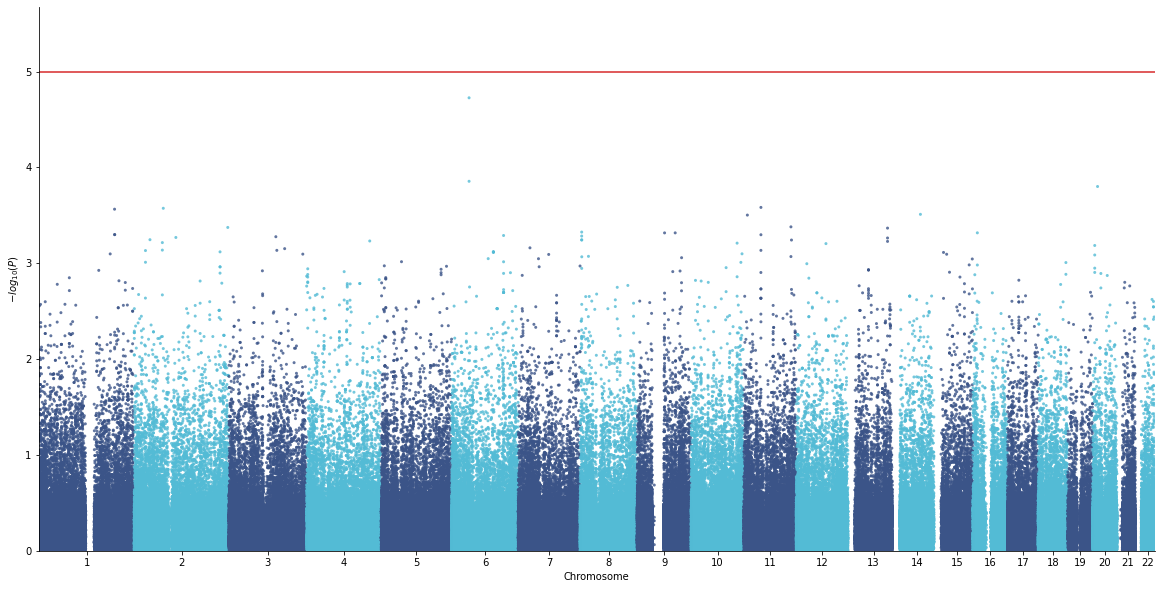

In [87]:
manhattanplot(assoc)

# QQplot

In an ideal GWAS case where there ARE causal polymorphisms, your QQ plotwill be a line with a tail

![](../images/QQplot_correct.png)

In [88]:
def qqplot(data, labels,title, filename=None, n_quantiles=99, alpha=0.95, error_type='theoretical', 
           distribution = 'beta',log10conv=True, figsize = (15,8), color=['b','r'], fill_dens=[0.2], type = 'uniform'):
    '''
    Function for plotting Quantile Quantile (QQ) plots with confidence interval (CI)
    :param data: NumPy 1D array with data
    :param labels:
    :param type: type of the plot
    :param n_quantiles: number of quntiles to plot
    :param alpha: confidence interval
    :param distribution: beta/normal/binomial -- type of the error estimation. Most common in the literature is 'beta'.
    :param log10conv: conversion to -log10(p) for the figure
    :return: nothing
    '''
    xmax = 0
    ymax = 0
    if len(fill_dens)<len(data):
        fill_dens.extend([fill_dens[0]]*(len(data)-len(fill_dens)))
    if type == 'uniform':
        # we expect distribution from 0 to 1
        for j in range(len(data)):
            # define quantiles positions:
            q_pos = np.concatenate([np.arange(99.)/len(data[j]), np.logspace(-np.log10(len(data[j]))+2, 0, n_quantiles)])
            # define quantiles in data
            q_data = mquantiles(data[j], prob=q_pos, alphap=0, betap=1, limit=(0, 1)) # linear interpolation
            # define theoretical predictions
            q_th = q_pos.copy()
            # evaluate errors
            q_err = np.zeros([len(q_pos),2])
            if np.sum(alpha) > 0:
                for i in range(0, len(q_pos)):
                    if distribution == 'beta':
                        q_err[i, :] = beta.interval(alpha, len(data[j])*q_pos[i], len(data[j]) - len(data[j])*q_pos[i])
                    elif distribution == 'binomial':
                        q_err[i, :] = binom.interval(alpha=alpha, n=len(data[j]), p=q_pos[i])
                    elif distribution == 'normal':
                        q_err[i, :] = norm.interval(alpha, len(data[j])*q_pos[i], np.sqrt(len(data[j])*q_pos[i]*(1.-q_pos[i])))
                    else:
                        print('Distribution is not defined!')
                q_err[i, q_err[i, :] < 0] = 1e-15
                if (distribution == 'binomial') | (distribution == 'normal'):
                    q_err /= 1.0*len(data[j])
                    for i in range(0, 100):
                        q_err[i,:] += 1e-15
            # print(q_err[100:, :])
            slope, intercept, r_value, p_value, std_err = linregress(q_th, q_data)
            # print(labels[j], ' -- Slope: ', slope, " R-squared:", r_value**2)
            fig, ax  = plt.subplots(figsize = figsize)
            ax.plot(-np.log10(q_th[n_quantiles-1:]), -np.log10(q_data[n_quantiles-1:]), '-', color=color[j])
            ax.plot(-np.log10(q_th[:n_quantiles]), -np.log10(q_data[:n_quantiles]), '.', color=color[j], label=labels[j])
            xmax = np.max([xmax, - np.log10(q_th[1])])
            ymax = np.max([ymax, - np.log10(q_data[0])])
            # print(- np.log10(q_th[:]))
            if np.sum(alpha)>0:
                if error_type=='experimental':
                    ax.fill_between(-np.log10(q_th), -np.log10(q_data/q_th*q_err[:,0]), -np.log10(q_data/q_th*q_err[:,1]), color=color[j], alpha=fill_dens[j], label='%1.3f CI'%alpha)
        if np.sum(alpha)>0:
            if error_type=='theoretical':
                ax.fill_between(-np.log10(q_th), -np.log10(q_err[:,0]), -np.log10(q_err[:,1]), color='grey', alpha=fill_dens[j], label='%1.3f CI'%alpha)
    ax.legend(loc=4)
    ax.set_xlabel('Theoretical -log10')
    ax.set_ylabel('Experimental -log10')
    ax.plot([0, 100], [0, 100],'--k')
    #print(q_th)
    #print(xmax,ymax)
    ax.set_xlim([0, np.ceil(xmax)])
    ax.set_ylim([0, np.ceil(ymax+q_th[-1]*1)])
    ax.set_title(title)
    plt.tight_layout()
    if filename!=None: plt.savefig(filename+'_QQ.png',bbox_inches='tight',pad_inches=0.05) 
    # return q_data, q_th, q_err

/tmp/ipykernel_1666/839700645.py:49: RuntimeWarning: divide by zero encountered in log10
  ax.plot(-np.log10(q_th[:n_quantiles]), -np.log10(q_data[:n_quantiles]), '.', color=color[j], label=labels[j])
/tmp/ipykernel_1666/839700645.py:58: RuntimeWarning: divide by zero encountered in log10
  ax.fill_between(-np.log10(q_th), -np.log10(q_err[:,0]), -np.log10(q_err[:,1]), color='grey', alpha=fill_dens[j], label='%1.3f CI'%alpha)


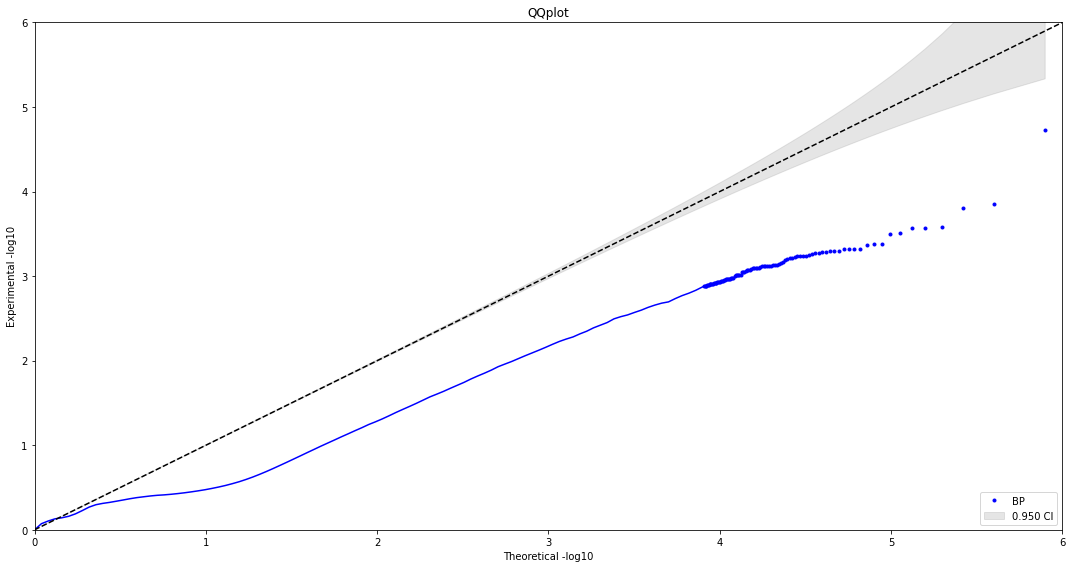

In [89]:
qqplot([assoc['P']], ['BP'],'QQplot')


### Now we will decide a the significance threshold and we will analyze the results.

Let's decide it with a criteria first, How you use Bonferroni correction here?

Too bad the challenge begins just now, the problem is that the post-GWAS analysis is an hot topic of research and there's no gold standards approaches, we will use FUMA software in order to analyze the significant SNPs that we got through our GWAS.
